In [52]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
from qbraid import device_wrapper, job_wrapper, get_jobs
from collections import Counter

In [56]:
def xx_pump(sys,env,p):
    yield cirq.CNOT(sys[1],sys[0])
    yield cirq.H(sys[1])
    yield cirq.X(env[0])
    yield cirq.CNOT(sys[1],env[0])
    yield cirq.Rx(rads=np.arccos(1-2*p)).on(sys[1]).controlled_by(env[0])
    yield cirq.CNOT(sys[1],env[0])

def zz_xx_pump(sys,env,p):
    yield cirq.CNOT(sys[1],sys[0])
    yield cirq.X(env[0])
    yield cirq.CNOT(sys[0],env[0])
    yield cirq.Rx(rads=np.arccos(1-2*p)).on(sys[0]).controlled_by(env[0])
    yield cirq.CNOT(sys[0],env[0])
    yield cirq.H(sys[1])
    yield cirq.X(env[1])
    yield cirq.CNOT(sys[1],env[1])
    yield cirq.Rx(rads=np.arccos(1-2*p)).on(sys[1]).controlled_by(env[1])
    yield cirq.CNOT(sys[1],env[1])

In [57]:
env = [cirq.LineQubit(0),cirq.LineQubit(3)]
sys = [cirq.LineQubit(1),cirq.LineQubit(2)]
probs = np.linspace(0,1,num=5)
repcnt = 1024

Mappings:

$\vert \phi+ \rangle = \vert 00 \rangle$

$\vert \psi+ \rangle = \vert 01 \rangle$

$\vert \phi- \rangle = \vert 10 \rangle$

$\vert \psi- \rangle = \vert 11 \rangle$

In [58]:
def calc_pump(pump,sys,env,p,repcnt):
    
    simulator = cirq.Simulator()
    final_hist = Counter()
    
    for j in range(2**2):
        circuit = cirq.Circuit()
        if (j&1) == 1:
            circuit.append(cirq.X.on(sys[0]))
        if (j&1) == 2:
            circuit.append(cirq.X.on(sys[1]))
        circuit.append(pump(sys,env,p))
        circuit.append(cirq.measure(sys, key = 'answer'))
        
        result = simulator.run(circuit,repetitions=repcnt)
        histogram = result.histogram(key = 'answer')
        final_hist += histogram

    for x in final_hist:
        final_hist[x]/=(4*repcnt)

    return final_hist

In [59]:
hists = [calc_pump(zz_xx_pump,sys,env,p,repcnt) for p in probs]

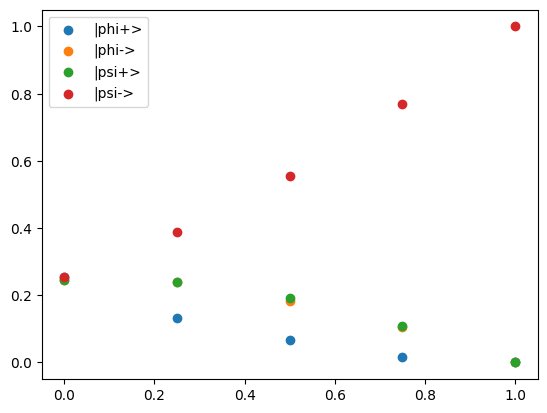

In [60]:
def calc_plot(hists):
    pops = [[],[],[],[]]
    for counts in hists:
        for i in range(4):
            pops[i].append(counts[i])

    plt.scatter(probs,pops[0],label='|phi+>')
    plt.scatter(probs,pops[1],label='|phi->')
    plt.scatter(probs,pops[2],label='|psi+>')
    plt.scatter(probs,pops[3],label='|psi->')
    plt.legend()
    plt.show()

calc_plot(hists)